# Project: WeRateDogs Tweet Analysis 

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction
In the project, I collected and cleaned the data form different sources to investigate WeRateDogs tweet account which rates dogs with humorous comment about the dog and gives them ratings.
The data I used for this project came form three different sources:
* The WeRateDogs Twitter archive
* The tweet image predictions according to a neural network
* Twitter API for additional tweet data 

In [1]:
import requests
import numpy as np
import pandas as pd
import tweepy
from tweepy import OAuthHandler
import json
from timeit import default_timer as timer
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### The question to investigate:
* What are the most common dog names?
* What are the most common breeds form the tweets?
* What is the most favorite dog breed?
* Is there any linear relationship among rating, favorite counts, and retweet counts?
* Can rating, retweet counts, or time be used to predict favorite counts?

<a id='wrangling'></a>
## Data Wrangling

### Gather Data

Read `image_predictions.tsv`.

In [2]:
df_twitter_archive = pd.read_csv('twitter-archive-enhanced.csv')

In [3]:
df_twitter_archive.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


Download `image_predictions.tsv` from the Internet.

In [4]:
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
response = requests.get(url)
with open('image_predictions.tsv', mode = 'wb') as file:
    file.write(response.content)

In [5]:
df_image_predictions = pd.read_csv('image_predictions.tsv',sep = '\t')

In [6]:
df_image_predictions.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


Query the Twitter API for each tweet's JSON data using Python's Tweepy library and store each tweet's entire set of JSON data in a file called `tweet_json.txt` file.

In [7]:
# Query Twitter API for each tweet in the Twitter archive and save JSON in a text file
# These are hidden to comply with Twitter's API terms and conditions
#consumer_key = 'HIDDEN'
#consumer_secret = 'HIDDEN'
#access_token = 'HIDDEN'
#access_secret = 'HIDDEN'

#auth = OAuthHandler(consumer_key, consumer_secret)
#auth.set_access_token(access_token, access_secret)

#api = tweepy.API(auth, wait_on_rate_limit=True)

#tweet_ids = df_1.tweet_id.values
#len(tweet_ids)

# Query Twitter's API for JSON data for each tweet ID in the Twitter archive
#count = 0
#fails_dict = {}
#start = timer()
# Save each tweet's returned JSON as a new line in a .txt file
#with open('tweet_json.txt', 'w') as outfile:
#    for tweet_id in tweet_ids:
#        count += 1
#        print(str(count) + ": " + str(tweet_id))
#        try:
#            tweet = api.get_status(tweet_id, tweet_mode='extended')
#            print("Success")
#            json.dump(tweet._json, outfile)
#           outfile.write('\n')
#        except tweepy.TweepError as e:
#            print("Fail")
#            fails_dict[tweet_id] = e
#            pass
#end = timer()
#print(end - start)
#print(fails_dict)

In [8]:
tweet = []
with open('tweet-json.txt') as f:
    for line in f:
        stats = json.loads(line)
        tweet_id = stats['id_str']
        retweet_count = stats['retweet_count']
        favorite_count = stats['favorite_count']
        tweet.append({'tweet_id': tweet_id,
                     'retweet_count': retweet_count,
                     'favorite_count': favorite_count})

df_tweet = pd.DataFrame(tweet, columns=['tweet_id','retweet_count','favorite_count'])

In [9]:
df_tweet.head()

,tweet_id,retweet_count,favorite_count
0,892420643555336193,8853,39467
1,892177421306343426,6514,33819
2,891815181378084864,4328,25461
3,891689557279858688,8964,42908
4,891327558926688256,9774,41048


### Assess Data

##### Visual Assessment

In [10]:
df_twitter_archive

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2351,666049248165822465,NaN,NaN,2015-11-16 00:24:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a 1949 1st generation vulpix. Enj...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666049248...,5,10,None,None,None,None,None
2352,666044226329800704,NaN,NaN,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a purebred Piers Morgan. Loves to Netf...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666044226...,6,10,a,None,None,None,None
2353,666033412701032449,NaN,NaN,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a very happy pup. Big fan of well-main...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666033412...,9,10,a,None,None,None,None
2354,666029285002620928,NaN,NaN,2015-11-15 23:05:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a western brown Mitsubishi terrier. Up...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666029285...,7,10,a,None,None,None,None


In [11]:
df_image_predictions

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
...,...,...,...,...,...,...,...,...,...,...,...,...
2070,891327558926688256,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True
2071,891689557279858688,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False
2072,891815181378084864,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
2073,892177421306343426,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True


In [12]:
df_tweet

,tweet_id,retweet_count,favorite_count
0,892420643555336193,8853,39467
1,892177421306343426,6514,33819
2,891815181378084864,4328,25461
3,891689557279858688,8964,42908
4,891327558926688256,9774,41048
...,...,...,...
2349,666049248165822465,41,111
2350,666044226329800704,147,311
2351,666033412701032449,47,128
2352,666029285002620928,48,132


##### Programmatic Assessment

In [13]:
df_twitter_archive.sample(5)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
2045,671528761649688577,NaN,NaN,2015-12-01 03:18:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Jax. He's in the middle of a serious conv...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/671528761...,10,10,Jax,None,None,None,None
2328,666396247373291520,NaN,NaN,2015-11-16 23:23:41 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Oh goodness. A super rare northeast Qdoba kang...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666396247...,9,10,None,None,None,None,None
803,772152991789019136,NaN,NaN,2016-09-03 19:23:13 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here's a couple rufferees making sure all the ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/772152991...,10,10,None,None,None,None,None
1288,708349470027751425,NaN,NaN,2016-03-11 17:50:48 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is River. He's changing the trumpet game....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/708349470...,11,10,River,None,None,None,None
1281,708810915978854401,NaN,NaN,2016-03-13 00:24:26 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Mister. He's a wonderful father to his...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/708810915...,10,10,Mister,None,None,None,None


In [14]:
df_twitter_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

In [15]:
df_image_predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [16]:
df_tweet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   tweet_id        2354 non-null   object
 1   retweet_count   2354 non-null   int64 
 2   favorite_count  2354 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 55.3+ KB


In [17]:
df_twitter_archive.query('name == "None"')

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
5,891087950875897856,NaN,NaN,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891087950...,13,10,None,None,None,None,None
7,890729181411237888,NaN,NaN,2017-07-28 00:22:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",When you watch your owner call another dog a g...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890729181...,13,10,None,None,None,None,None
12,889665388333682689,NaN,NaN,2017-07-25 01:55:32 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here's a puppo that seems to be on the fence a...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/889665388...,13,10,None,None,None,None,puppo
24,887343217045368832,NaN,NaN,2017-07-18 16:08:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",You may not have known you needed to see this ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/887343217...,13,10,None,None,None,None,None
25,887101392804085760,NaN,NaN,2017-07-18 00:07:08 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This... is a Jubilant Antarctic House Bear. We...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/887101392...,12,10,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2342,666082916733198337,NaN,NaN,2015-11-16 02:38:37 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a well-established sunblockerspan...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666082916...,6,10,None,None,None,None,None
2343,666073100786774016,NaN,NaN,2015-11-16 01:59:36 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Let's hope this flight isn't Malaysian (lol). ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666073100...,10,10,None,None,None,None,None
2344,666071193221509120,NaN,NaN,2015-11-16 01:52:02 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a northern speckled Rhododendron....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666071193...,9,10,None,None,None,None,None
2351,666049248165822465,NaN,NaN,2015-11-16 00:24:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a 1949 1st generation vulpix. Enj...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666049248...,5,10,None,None,None,None,None


In [18]:
df_twitter_archive

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2351,666049248165822465,NaN,NaN,2015-11-16 00:24:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a 1949 1st generation vulpix. Enj...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666049248...,5,10,None,None,None,None,None
2352,666044226329800704,NaN,NaN,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a purebred Piers Morgan. Loves to Netf...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666044226...,6,10,a,None,None,None,None
2353,666033412701032449,NaN,NaN,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a very happy pup. Big fan of well-main...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666033412...,9,10,a,None,None,None,None
2354,666029285002620928,NaN,NaN,2015-11-15 23:05:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a western brown Mitsubishi terrier. Up...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666029285...,7,10,a,None,None,None,None


In [19]:
df_twitter_archive[df_twitter_archive.rating_denominator != 10][['text', 'rating_numerator', 'rating_denominator']]

,text,rating_numerator,rating_denominator
313,@jonnysun @Lin_Manuel ok jomny I know you're e...,960,0
342,@docmisterio account started on 11/15/15,11,15
433,The floofs have been released I repeat the flo...,84,70
516,Meet Sam. She smiles 24/7 &amp; secretly aspir...,24,7
784,"RT @dog_rates: After so many requests, this is...",9,11
902,Why does this never happen at my front door......,165,150
1068,"After so many requests, this is Bretagne. She ...",9,11
1120,Say hello to this unbelievably well behaved sq...,204,170
1165,Happy 4/20 from the squad! 13/10 for all https...,4,20
1202,This is Bluebert. He just saw that both #Final...,50,50


In [20]:
df_twitter_archive.name.value_counts()

None       745
a           55
Charlie     12
Lucy        11
Cooper      11
          ... 
Beebop       1
Rueben       1
Flash        1
Peanut       1
Monty        1
Name: name, Length: 957, dtype: int64

#### Issues
##### Quality
`df_twitter_archive`
* Some rows are retweets or replys.
* Incorrect data in *name-puppo* column. (None is a string not null)
* The <a...> tag in *source* column.
* Unnecessary columns.(in_reply_to_status_id, in_reply_to_user_id, retweeted_status_id, retweeted_status_user_id, retweeted_status_timestamp)
* Incorrect data in *rating_denominator* and *rating_numerator* column where rating_denominator is not 10.
* rating_numerator of tweet_id 680494726643068929 is 26 instead of 11.26, 778027034220126208 is 27 instead of 11.27, and 786709082849828864 is 75 instead of 9.75.

`df_image_predictions`
* Nondescriptive column headers (p1 - p3_dog).
* Some tweets don't have dog but other animals in it.

`df_twitter_archive` & `df_image_predictions`
* *tweet_id* is an interger not a string.
* *tweet_id* in two tables is not the same.

##### Tidiness
* `df_twitter_archive`: one variable in four columns (doggo, floofer, pupper, and puppo).
* `df_tweet`: should be part of `df_twitter_archive`.
* prediction of dog breed in several columns and shoud be part of  `df_twitter_archive` table.

### Clean Data

In [21]:
# Make a copy of original Dataframe
twitter_archive_clean = df_twitter_archive.copy()
image_predictions_clean = df_image_predictions.copy()
tweet_clean = df_tweet.copy()

#### Quality

#### 1. *tweet_id* is an interger not a string in `df_twitter_archive` and `df_image_predictions` table.

##### Define
Convert the *tweet_id* column's data type from an integer to a string using `astype`.

##### Code

In [22]:
twitter_archive_clean.tweet_id = twitter_archive_clean.tweet_id.astype(str)
image_predictions_clean.tweet_id = image_predictions_clean.tweet_id.astype(str)

##### Test

In [23]:
twitter_archive_clean.tweet_id.head()

0    892420643555336193
1    892177421306343426
2    891815181378084864
3    891689557279858688
4    891327558926688256
Name: tweet_id, dtype: object

In [24]:
image_predictions_clean.tweet_id.head()

0    666020888022790149
1    666029285002620928
2    666033412701032449
3    666044226329800704
4    666049248165822465
Name: tweet_id, dtype: object

#### 2. Some rows are retweets or replys.

##### Define
Drop the rows which are retweets or replys.

##### Code

In [25]:
twitter_archive_clean = twitter_archive_clean[(twitter_archive_clean.in_reply_to_status_id.isnull()) & 
                                              (twitter_archive_clean.retweeted_status_id.isnull())]

##### Test

In [26]:
twitter_archive_clean[(twitter_archive_clean.in_reply_to_status_id.notnull()) | 
                      (twitter_archive_clean.retweeted_status_id.notnull())]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


#### Tidiness

#### 1. `df_tweet` should be part of `df_twitter_archive`.

##### Define
Merge `df_tweet` into `df_twitter_archive` on *tweet_id* column.

##### Code

In [27]:
twitter_archive_clean = pd.merge(twitter_archive_clean, tweet_clean, on=['tweet_id'],how='left')

##### Test

In [28]:
twitter_archive_clean.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,retweet_count,favorite_count
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None,8853,39467
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None,6514,33819
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None,4328,25461
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None,8964,42908
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None,9774,41048


#### 2. One variable in four columns (doggo, floofer, pupper, and puppo) in `df_twitter_archive` table.

##### Define 
Replace None in doggo - puppo columns with empty string and concatenate those columns into *dog_stage* column. Drop the doggo - puppo columns.

##### Code

In [29]:
# Replace None in doggo - puppo columns with empty string
columns = ['doggo', 'floofer', 'pupper', 'puppo']
for column in columns:
    twitter_archive_clean[column].replace('None', '', inplace=True)

In [30]:
# Concatenate those columns into *dog_stage* column 
twitter_archive_clean['dog_stage'] = twitter_archive_clean['doggo'] + twitter_archive_clean['floofer'] + \
twitter_archive_clean['pupper'] + twitter_archive_clean['puppo']

In [31]:
# Drop the doggo - puppo columns
twitter_archive_clean.drop(['doggo', 'floofer', 'pupper', 'puppo'], axis=1, inplace=True)

In [32]:
# handle multiple stages
twitter_archive_clean.loc[twitter_archive_clean.dog_stage == 'doggopupper', 'dog_stage'] = 'doggo, pupper'
twitter_archive_clean.loc[twitter_archive_clean.dog_stage == 'doggopuppo', 'dog_stage'] = 'doggo, puppo'
twitter_archive_clean.loc[twitter_archive_clean.dog_stage == 'doggofloofer', 'dog_stage'] = 'doggo, floofer'

##### Test

In [33]:
twitter_archive_clean['dog_stage'].value_counts()

                  1761
pupper             221
doggo               72
puppo               23
doggo, pupper        9
floofer              9
doggo, puppo         1
doggo, floofer       1
Name: dog_stage, dtype: int64

In [34]:
twitter_archive_clean.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,retweet_count,favorite_count,dog_stage
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,8853,39467,
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,6514,33819,
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,4328,25461,
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,8964,42908,
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,9774,41048,


#### Quality

#### 3. Incorrect data in *name* & *dog_stage* column

##### Define
Replace None and a in *name* and empty string in *dog_stage* with null, and seperate double stages with comma.

##### Code

In [35]:
twitter_archive_clean['name'].replace('None', np.nan, inplace=True)
twitter_archive_clean['name'].replace('a', np.nan, inplace=True)
twitter_archive_clean['dog_stage'].replace('', np.nan, inplace=True)

In [36]:
twitter_archive_clean.loc[twitter_archive_clean.dog_stage == 'doggopupper', 'dog_stage'] = 'doggo, pupper'
twitter_archive_clean.loc[twitter_archive_clean.dog_stage == 'doggofloofer', 'dog_stage'] = 'doggof, loofer'
twitter_archive_clean.loc[twitter_archive_clean.dog_stage == 'doggopuppo', 'dog_stage'] = 'doggo, puppo'

##### Test

In [37]:
twitter_archive_clean.dog_stage.unique()

array([nan, 'doggo', 'puppo', 'pupper', 'floofer', 'doggo, puppo',
       'doggo, floofer', 'doggo, pupper'], dtype=object)

In [38]:
twitter_archive_clean.dog_stage.value_counts()

pupper            221
doggo              72
puppo              23
doggo, pupper       9
floofer             9
doggo, puppo        1
doggo, floofer      1
Name: dog_stage, dtype: int64

In [39]:
twitter_archive_clean.name.value_counts()

Charlie    11
Lucy       11
Oliver     10
Cooper     10
Penny       9
           ..
Cupid       1
Mack        1
Apollo      1
Iroh        1
Monty       1
Name: name, Length: 953, dtype: int64

#### 4. The <a...> tag in *source* column.

##### Define
Replace the tag with empty string.

##### Code

In [40]:
twitter_archive_clean.source = twitter_archive_clean.source.str.replace(r'<.*?>', '')

##### Test

In [41]:
twitter_archive_clean.source.value_counts()

Twitter for iPhone     1964
Vine - Make a Scene      91
Twitter Web Client       31
TweetDeck                11
Name: source, dtype: int64

#### 5. Incorrect data in *rating_denominator* and *rating_numerator* column where rating_denominator is not 10.

##### Define
Drop the rows where *rating_denominator* is 7, 11, 20, or 2. Then divide *rating_numerator* by *rating_denominator* to calculate the ratio and store it in *rating* column.

##### Code

In [42]:
twitter_archive_clean = twitter_archive_clean[~((twitter_archive_clean.rating_denominator == 7) | 
                     (twitter_archive_clean.rating_denominator == 11) |
                     (twitter_archive_clean.rating_denominator == 20) |
                     (twitter_archive_clean.rating_denominator == 2))]

In [43]:
twitter_archive_clean['rating'] = twitter_archive_clean.rating_numerator / twitter_archive_clean.rating_denominator

##### Test

In [44]:
twitter_archive_clean[((twitter_archive_clean.rating_denominator == 7) | 
                     (twitter_archive_clean.rating_denominator == 11) |
                     (twitter_archive_clean.rating_denominator == 20) |
                     (twitter_archive_clean.rating_denominator == 2))]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,retweet_count,favorite_count,dog_stage,rating


In [45]:
twitter_archive_clean['rating'].sort_values()

246       0.0
2079      0.1
1625      0.1
2003      0.1
1838      0.1
        ...  
1474      2.6
586       2.7
528       7.5
1821     42.0
770     177.6
Name: rating, Length: 2092, dtype: float64

#### 6. Unnecessary columns.

##### Define
Drop the unnecessary columns (in_reply_to_status_id, in_reply_to_user_id, retweeted_status_id, retweeted_status_user_id, retweeted_status_timestamp).

##### Code

In [46]:
twitter_archive_clean.drop(['in_reply_to_status_id', 'in_reply_to_user_id', 'retweeted_status_id', 
                           'retweeted_status_user_id', 'retweeted_status_timestamp'], axis=1, inplace=True)

##### Test

In [47]:
twitter_archive_clean.head()

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,retweet_count,favorite_count,dog_stage,rating
0,892420643555336193,2017-08-01 16:23:56 +0000,Twitter for iPhone,This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,8853,39467,NaN,1.3
1,892177421306343426,2017-08-01 00:17:27 +0000,Twitter for iPhone,This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,6514,33819,NaN,1.3
2,891815181378084864,2017-07-31 00:18:03 +0000,Twitter for iPhone,This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,4328,25461,NaN,1.2
3,891689557279858688,2017-07-30 15:58:51 +0000,Twitter for iPhone,This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,8964,42908,NaN,1.3
4,891327558926688256,2017-07-29 16:00:24 +0000,Twitter for iPhone,This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,9774,41048,NaN,1.2


#### 7.  Nondescriptive column headers (p1 - p3_dog).

##### Define
Select all nondescriptive headers (p1 - p3_dog) and rename them with full words (top_prediction - third_prediction_dog).

##### Code

In [48]:
image_predictions_clean.rename(columns={'p1': 'top_prediction',
                                       'p1_conf': 'top_prediction_confidence',
                                       'p1_dog': 'top_prediction_dog',
                                       'p2': 'second_prediction',
                                       'p2_conf': 'second_prediction_confidence',
                                       'p2_dog': 'second_prediction_dog',
                                       'p3': 'third_prediction',
                                       'p3_conf': 'third_prediction_confidence',
                                       'p3_dog': 'third_prediction_dog'}, inplace=True)

##### Test

In [49]:
image_predictions_clean.head()

,tweet_id,jpg_url,img_num,top_prediction,top_prediction_confidence,top_prediction_dog,second_prediction,second_prediction_confidence,second_prediction_dog,third_prediction,third_prediction_confidence,third_prediction_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


#### 8. *tweet_id* in `df_twitter_archive` and `df_image_predictions` table is not the same.

##### Define
Isolate the *tweet_id* in `df_image_predictions` table and merge it with `df_twitter_archive` table. Then isolate the *tweet_id* in `df_twitter_archive` table and merge it with `df_image_predictions` table.

##### Code

In [50]:
df = pd.DataFrame(image_predictions_clean['tweet_id'])
twitter_archive_clean = pd.merge(df, twitter_archive_clean)

df = pd.DataFrame(twitter_archive_clean['tweet_id'])
image_predictions_clean = pd.merge(df, image_predictions_clean)

##### Test

In [51]:
(twitter_archive_clean.tweet_id == image_predictions_clean.tweet_id).sum()

1966

#### Tidiness

#### 3. prediction of dog breed in several columns and shoud be part of  `df_twitter_archive` table.

##### Define
Create one column for dog breed prediction and a new DataFrame `df_prediction`. Then merge it with `df_twitter_archive` table.

##### Code

In [52]:
prediction = []
for index, row in image_predictions_clean.iterrows():
    if row.top_prediction_dog:
        prediction.append({'tweet_id': row['tweet_id'],
                          'dog_breed': row['top_prediction']})
    elif row.second_prediction_dog:
        prediction.append({'tweet_id': row['tweet_id'],
                          'dog_breed': row['second_prediction']})
    elif row.third_prediction_dog:
        prediction.append({'tweet_id': row['tweet_id'],
                          'dog_breed': row['third_prediction']})
    else:
        prediction.append({'tweet_id': row['tweet_id'],
                          'dog_breed': np.nan})
df_prediction = pd.DataFrame(prediction)

In [53]:
twitter_archive_clean = pd.merge(twitter_archive_clean, df_prediction, on='tweet_id')

##### Test

In [54]:
twitter_archive_clean.head()

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,retweet_count,favorite_count,dog_stage,rating,dog_breed
0,666020888022790149,2015-11-15 22:32:08 +0000,Twitter for iPhone,Here we have a Japanese Irish Setter. Lost eye...,https://twitter.com/dog_rates/status/666020888...,8,10,NaN,532,2535,NaN,0.8,Welsh_springer_spaniel
1,666029285002620928,2015-11-15 23:05:30 +0000,Twitter for iPhone,This is a western brown Mitsubishi terrier. Up...,https://twitter.com/dog_rates/status/666029285...,7,10,NaN,48,132,NaN,0.7,redbone
2,666033412701032449,2015-11-15 23:21:54 +0000,Twitter for iPhone,Here is a very happy pup. Big fan of well-main...,https://twitter.com/dog_rates/status/666033412...,9,10,NaN,47,128,NaN,0.9,German_shepherd
3,666044226329800704,2015-11-16 00:04:52 +0000,Twitter for iPhone,This is a purebred Piers Morgan. Loves to Netf...,https://twitter.com/dog_rates/status/666044226...,6,10,NaN,147,311,NaN,0.6,Rhodesian_ridgeback
4,666049248165822465,2015-11-16 00:24:50 +0000,Twitter for iPhone,Here we have a 1949 1st generation vulpix. Enj...,https://twitter.com/dog_rates/status/666049248...,5,10,NaN,41,111,NaN,0.5,miniature_pinscher


#### Quality

#### 9. Some tweets don't have dog but other animals in it.

##### Define
Drop the rows which *dog_breed* is null.

##### Code

In [55]:
twitter_archive_clean = twitter_archive_clean[twitter_archive_clean.dog_breed.notnull()]

##### Test

In [56]:
twitter_archive_clean[twitter_archive_clean.dog_breed.isnull()]

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,retweet_count,favorite_count,dog_stage,rating,dog_breed


#### 10. rating_numerator of tweet_id 680494726643068929 is 26 instead of 11.26, 778027034220126208 is 27 instead of 11.27, and 786709082849828864 is 75 instead of 9.75.

##### Define
Use advance indexing to isolate the row where tweet_id 680494726643068929/778027034220126208/786709082849828864 and covert the entry in its rating_numerator field form 26/27/75 to 11.26/11.27/9.75. Then recalculate the rating.

##### Code

In [57]:
twitter_archive_clean.loc[twitter_archive_clean.tweet_id == "680494726643068929", 'rating_numerator'] = 11.26
twitter_archive_clean.loc[twitter_archive_clean.tweet_id == "778027034220126208", 'rating_numerator'] = 11.27
twitter_archive_clean.loc[twitter_archive_clean.tweet_id == "786709082849828864", 'rating_numerator'] = 9.75

In [58]:
twitter_archive_clean['rating'] = twitter_archive_clean.rating_numerator / twitter_archive_clean.rating_denominator

##### Test

In [59]:
# 1.4 should be the highest
twitter_archive_clean.rating.sort_values()

1733    0.0
562     0.2
105     0.2
1010    0.3
166     0.3
       ... 
1671    1.4
1570    1.4
1916    1.4
1693    1.4
1655    1.4
Name: rating, Length: 1661, dtype: float64

### Store Data
Store the clean DataFrame(s) in a CSV file with the main one named twitter_archive_master.csv. 

In [60]:
twitter_archive_clean.to_csv('twitter_archive_master.csv', index=False)

<a id='eda'></a>
## Exploratory Data Analysis

In [61]:
df = pd.read_csv('twitter_archive_master.csv')

In [62]:
df.head()

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,retweet_count,favorite_count,dog_stage,rating,dog_breed
0,666020888022790149,2015-11-15 22:32:08 +0000,Twitter for iPhone,Here we have a Japanese Irish Setter. Lost eye...,https://twitter.com/dog_rates/status/666020888...,8.0,10,NaN,532,2535,NaN,0.8,Welsh_springer_spaniel
1,666029285002620928,2015-11-15 23:05:30 +0000,Twitter for iPhone,This is a western brown Mitsubishi terrier. Up...,https://twitter.com/dog_rates/status/666029285...,7.0,10,NaN,48,132,NaN,0.7,redbone
2,666033412701032449,2015-11-15 23:21:54 +0000,Twitter for iPhone,Here is a very happy pup. Big fan of well-main...,https://twitter.com/dog_rates/status/666033412...,9.0,10,NaN,47,128,NaN,0.9,German_shepherd
3,666044226329800704,2015-11-16 00:04:52 +0000,Twitter for iPhone,This is a purebred Piers Morgan. Loves to Netf...,https://twitter.com/dog_rates/status/666044226...,6.0,10,NaN,147,311,NaN,0.6,Rhodesian_ridgeback
4,666049248165822465,2015-11-16 00:24:50 +0000,Twitter for iPhone,Here we have a 1949 1st generation vulpix. Enj...,https://twitter.com/dog_rates/status/666049248...,5.0,10,NaN,41,111,NaN,0.5,miniature_pinscher


### What are the most common dog names?


In [63]:
df.name.value_counts()

Charlie     10
Lucy        10
Cooper      10
Oliver       9
Tucker       9
            ..
Jomathan     1
Bloop        1
Cupid        1
Mack         1
Monty        1
Name: name, Length: 848, dtype: int64

**Charlie, Cooper, and Lucy are the most common dog names.**

### What are the most common breeds form the tweets?

In [64]:
df.dog_breed.value_counts()

golden_retriever        154
Labrador_retriever      106
Pembroke                 94
Chihuahua                89
pug                      62
                       ... 
Irish_wolfhound           1
EntleBucher               1
Bouvier_des_Flandres      1
standard_schnauzer        1
Japanese_spaniel          1
Name: dog_breed, Length: 113, dtype: int64

**Golden_retriever, Labrador_retriever, Pembroke, Chihuahua, and Pug are the top five most common breeds form the tweets.**

### What is the most favorite dog breed?

##### Top five dog breed by favorite counts.

In [65]:
top5_breed_fav = df.groupby('dog_breed').sum().favorite_count.nlargest(5)
top5_breed_fav

dog_breed
golden_retriever      1917207.0
Labrador_retriever    1265355.0
Pembroke              1038797.0
Chihuahua              717450.0
Samoyed                583906.0
Name: favorite_count, dtype: float64

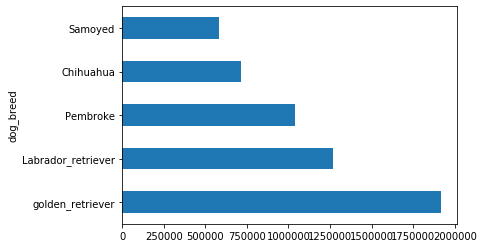

In [66]:
top5_breed_fav.plot(kind='barh');

##### Average favorite counts for the top five dog breed.

In [67]:
average_fav = df.groupby('dog_breed').mean().favorite_count[['golden_retriever', 'Labrador_retriever',
                                                             'Pembroke', 'Chihuahua','Samoyed']] 
average_fav

dog_breed
golden_retriever      12449.396104
Labrador_retriever    11937.311321
Pembroke              11051.031915
Chihuahua              8061.235955
Samoyed               13902.523810
Name: favorite_count, dtype: float64

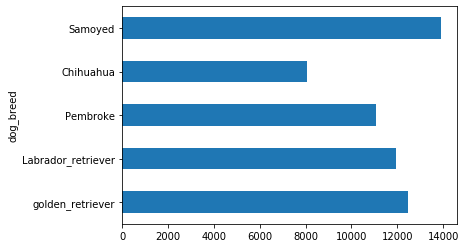

In [68]:
average_fav.plot(kind='barh');

##### Top five dog breed by retweet counts.

In [69]:
top5_breed_retweet = df.groupby('dog_breed').sum().retweet_count.nlargest(5)
top5_breed_retweet

dog_breed
golden_retriever      575782.0
Labrador_retriever    405404.0
Pembroke              291771.0
Chihuahua             235679.0
Samoyed               203446.0
Name: retweet_count, dtype: float64

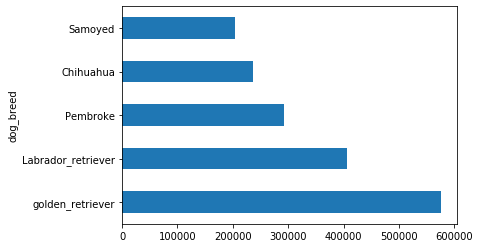

In [70]:
top5_breed_retweet.plot(kind='barh');

##### Average retweet counts for the top five dog breed.

In [71]:
average_retweet = df.groupby('dog_breed').mean().retweet_count[['golden_retriever', 'Labrador_retriever',
                                                                'Pembroke', 'Chihuahua','Samoyed']] 
average_retweet

dog_breed
golden_retriever      3738.844156
Labrador_retriever    3824.566038
Pembroke              3103.946809
Chihuahua             2648.078652
Samoyed               4843.952381
Name: retweet_count, dtype: float64

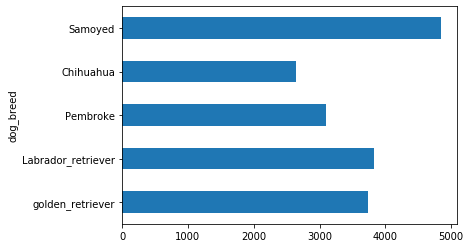

In [72]:
average_retweet.plot(kind='barh');

##### Average rating for the top five dog breed.

In [73]:
top5_rate_breed = df.groupby('dog_breed').mean().rating[['golden_retriever', 'Labrador_retriever',
                                                         'Pembroke', 'Chihuahua','Samoyed']]
top5_rate_breed

dog_breed
golden_retriever      1.155195
Labrador_retriever    1.119811
Pembroke              1.142553
Chihuahua             1.053933
Samoyed               1.169048
Name: rating, dtype: float64

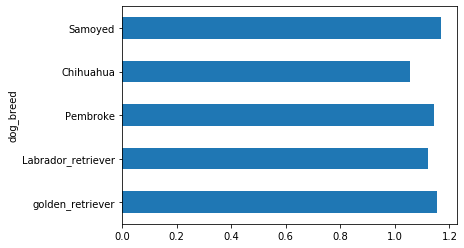

In [74]:
top5_rate_breed.plot(kind='barh');

**Golden_retriever is the most favorite dog breed by total favorite counts and retweet counts. However, among the top five dog breed by favorite and retweet counts, Samoyed has the most average favorite counts, retweet counts, and rating for a tweet.**

### Is there any linear relationship among rating, favorite counts, and retweet counts?


We can see that *retweet_count*, *favorite_count*, and *rating* are correlated with one another. Among them, *retweet_count* and *favorite_count* have significant linear relationship as its R-squared is closer to 1, while *rating* and *retweet_count*/*favorite_count* have weak linear relationship.

In [75]:
import seaborn as sns
import statsmodels.api as sm

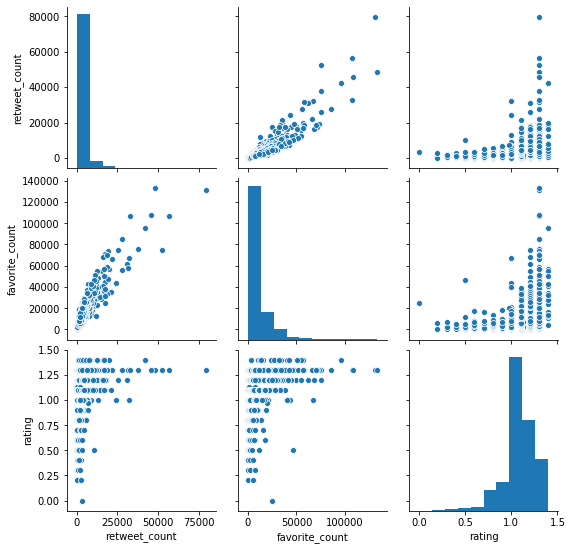

In [76]:
# Create a scatter plot matrix
sns.pairplot(df[['retweet_count','favorite_count','rating']]);

In [77]:
# Calculate correlation coefficient between retweet_count and favorite_count
df.retweet_count.corr(df.favorite_count)

0.9134665178197482

In [78]:
# Calculate correlation coefficient between retweet_count and rating
df.retweet_count.corr(df.rating)

0.3209356781612716

In [79]:
# Calculate correlation coefficient between favorite_count and rating
df.favorite_count.corr(df.rating)

0.4255232415026048

**From the scatter plot matrix, we can see that *retweet_count*, *favorite_count*, and *rating* are correlated with one another. Among them, *retweet_count* and *favorite_count* have strong linear relationship as its correlation coefficient is closer to 1, while *rating* and *retweet_count*/*favorite_count* have weak linear relationship.**

### Can rating, retweet counts, or time be used to predict favorite counts?

##### Create a simple linear regression between favorite_count and rating

In [80]:
# Fit the model with rating
df['intercept'] = 1
ml = sm.OLS(df['favorite_count'], df[['intercept','rating']])
res = ml.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         favorite_count   R-squared:                       0.181
Model:                            OLS   Adj. R-squared:                  0.181
Method:                 Least Squares   F-statistic:                     366.8
Date:                Mon, 19 Oct 2020   Prob (F-statistic):           5.01e-74
Time:                        14:14:44   Log-Likelihood:                -17879.
No. Observations:                1661   AIC:                         3.576e+04
Df Residuals:                    1659   BIC:                         3.577e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept  -2.349e+04   1733.934    -13.546      0.000   -2.69e+04   -2.01e+04
rating      3.029e+04   1581.332     19.152      0.000    2.72e+04    3.34e+04
==============================================================================
Omnibus:                     1417.672   Durbin-Watson:                   1.494
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            47572.377
Skew:                           3.866   Prob(JB):                         0.00
Kurtosis:                      28.052   Cond. No.                         12.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

##### Create a simple linear regression between favorite_count and retweet_count.

In [81]:
# Fit the model with retweet_count
df['intercept'] = 1
ml = sm.OLS(df['favorite_count'], df[['intercept','retweet_count']])
res = ml.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         favorite_count   R-squared:                       0.834
Model:                            OLS   Adj. R-squared:                  0.834
Method:                 Least Squares   F-statistic:                     8360.
Date:                Mon, 19 Oct 2020   Prob (F-statistic):               0.00
Time:                        14:14:44   Log-Likelihood:                -16551.
No. Observations:                1661   AIC:                         3.311e+04
Df Residuals:                    1659   BIC:                         3.312e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
intercept      2516.6014    146.391     17.191      0.000    2229.472    2803.731
retweet_count     2.3936      0.026     91.435      0.000       2.342       2.445
==============================================================================
Omnibus:                      502.706   Durbin-Watson:                   0.783
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            36811.168
Skew:                          -0.475   Prob(JB):                         0.00
Kurtosis:                      26.043   Cond. No.                     6.48e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.48e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

##### Create a multiple regression between favorite_count, retweet_count, and rating.

In [82]:
# Fot the model with retweet_count, and rating
df['intercept'] = 1
ml = sm.OLS(df['favorite_count'], df[['intercept','rating','retweet_count']])
res = ml.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         favorite_count   R-squared:                       0.854
Model:                            OLS   Adj. R-squared:                  0.854
Method:                 Least Squares   F-statistic:                     4847.
Date:                Mon, 19 Oct 2020   Prob (F-statistic):               0.00
Time:                        14:14:45   Log-Likelihood:                -16447.
No. Observations:                1661   AIC:                         3.290e+04
Df Residuals:                    1658   BIC:                         3.292e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
intercept     -8496.3454    752.286    -11.294      0.000   -9971.875   -7020.815
rating          1.05e+04    705.314     14.890      0.000    9118.906    1.19e+04
retweet_count     2.2695      0.026     87.400      0.000       2.219       2.320
==============================================================================
Omnibus:                      437.821   Durbin-Watson:                   1.021
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            30124.574
Skew:                          -0.185   Prob(JB):                         0.00
Kurtosis:                      23.860   Cond. No.                     4.84e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.84e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [83]:
# Calculate the VIFs for each variable in the model to test multicollinerity
y, X = dmatrices('favorite_count ~ rating + retweet_count', df, return_type='dataframe')
vif = pd.DataFrame()
vif['VIF Factor'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['features'] = X.columns
vif

,VIF Factor,features
0,40.186656,Intercept
1,1.114827,rating
2,1.114827,retweet_count


##### Create a multiple regression between favorite_count, retweet_count, rating, and time.

In [84]:
# Check the time range
df.timestamp.min(), df.timestamp.max()

('2015-11-15 22:32:08 +0000', '2017-08-01 00:17:27 +0000')

In [85]:
# Convert object to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])

In [86]:
# Create new column for year
df['year'] = pd.DatetimeIndex(df['timestamp']).year

In [87]:
# Create dummy variables for year
df[['2015','2016','2017']] = pd.get_dummies(df['year'])

In [88]:
# Fit the model with rating, retweet_count, and year
df['intercept'] = 1
ml = sm.OLS(df['favorite_count'], df[['intercept','rating','retweet_count','2015','2016']])
res = ml.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         favorite_count   R-squared:                       0.926
Model:                            OLS   Adj. R-squared:                  0.926
Method:                 Least Squares   F-statistic:                     5192.
Date:                Mon, 19 Oct 2020   Prob (F-statistic):               0.00
Time:                        14:14:45   Log-Likelihood:                -15881.
No. Observations:                1661   AIC:                         3.177e+04
Df Residuals:                    1656   BIC:                         3.180e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
intercept      9782.2792    710.506     13.768      0.000    8388.694    1.12e+04
rating         1456.1550    560.549      2.598      0.009     356.695    2555.615
retweet_count     2.0967      0.019    110.414      0.000       2.059       2.134
2015          -1.093e+04    293.182    -37.264      0.000   -1.15e+04   -1.04e+04
2016          -9273.1717    246.951    -37.551      0.000   -9757.540   -8788.803
==============================================================================
Omnibus:                      549.470   Durbin-Watson:                   1.360
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            50084.571
Skew:                          -0.563   Prob(JB):                         0.00
Kurtosis:                      29.878   Cond. No.                     6.09e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.09e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

**Since the multiple regression model with rating, retweet_count, and year has the highest R-squared and the p-value of 0 for each variable, we can conclude that rating, retweet_count, and year can be used to predict favorite counts.**

<a id='conclusions'></a>
## Conclusions

Golden_retriever is the most favorite dog breed by total favorite counts and retweet counts. However, among the top five dog breed by favorite and retweet counts, Samoyed has the most average favorite counts, retweet counts, and rating for a tweet. 

From simple linear regression model, I found that retweet counts can be used to predict favorite counts as R-squared equals to 0.834 and the p-value for retweet counts is 0. For every one count increse in retweet, the predicted increase in favorite counts is by 2.3936. On the contrary, rating is not a good variable to predict favorite counts as the R-squared is only 0.181.

From multiple linear regression model, I found that rating, retweet_count, and year can be used to predict favorite counts as R-squared equals to 0.926 and the p-value for each variable is 0. The predicted difference between the year of 2015/2016 and 2017, holding all other variables constant is -10930/-9273, suggesting that favorite counts increase over time due to the growth in popularity of the twitter account.

To sum up, the popularity of a tweet increases over time as the twitter account grows, while the rating of a tweet alone donesn't have much impact on the popularity. I assume that the popularity of a tweet would be affected by other variables such as the assets(images or videos) or the dog stage, but I don't have enough data to test the hypothesis.